<a href="https://colab.research.google.com/github/hermansolem/FOR_Labs_22-23/blob/master/lab4/lab4_location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab #4, part I: tight models and inequalities

In this lab we'll see two well-known optimization problems, which will show how modeling techniques and valid inequalities can help tighten the LP relaxation. Specifically:

1. For a location problem, which is a discrete optimization problem, we take its LP relaxation. We start from a "weak" formulation and see how adding inequalities from a "stronger" formulation can help increasing the lower bound and how it changes the solution to the LP problem.

2. (See part II in a separate notebook) For the _knapsack_ problem, we begin from its LP relaxation and introduce _cover_ inequalities, and see what impact they have on the dual bound and on the solution itself.

## Facility location
A region wants to build $p$ airports to serve a set $N = \{0,1,\ldots{},n-1\}$ of $n$ cities. There are $m>p$ candidate sites for the airports, each with an estimate cost $c_j$ to build an airport at location $j$ for $j\in M=\{0,1,...,m-1\}$.

Each airport can serve a subset of cities, and it is assumed that every city $i$ is served by __one__ airport $j$. The 20-year cost of maintaining the road between city $i$ and airport $j$, mostly proportional to the distance between $i$ and $j$, is denoted as $d_{ij}$. It is calculated as $400k$ euro per km.

Formulate the problem of _locating_ the $p$ airport sites as a discrete optimization problem.

### Model

The model contains:
* Sets: $N$ (set of cities), $M$ (set of candidate sites);
* Indices: $i$ for cities, $j$ for sites;
* Parameters: $c_j$ (cost of building airport at $j$), $d_{ij}$ (maintenance cost of road between city $i$ and airport $j$).

There are two classes of variables for this problem:

* binary variable $y_j$ for $j\in M$: it is 1 if an airport is built at candidate site $j$, 0 otherwise;
* binary variable $x_{ij}$ for $i \in N$, $j\in M$: 1 if city $i$ is associated with (i.e. served by) airport $j$.

The objective function, to be minimized, is the total (building + road maintenance) cost:

$$
\sum_{j \in M} c_j y_j + \sum_{i\in N} \sum_{j\in M} d_{ij} x_{ij}.
$$

The constraints are as follows:

* $p$ airports must be built: $\sum_{j\in M} y_j = p$;
* for each city $i$: city $i$ is served by one airport: $\sum_{j\in M} x_{ij} = 1 \forall i\in N$;
* the last class of constraints is tricky: if one or more cities $i\in N$ are served by airport $j$, then $y_j$ must be 1. This constraint is not explicit in the definition of the problem, but it is a result of our modeling choice with variables. We'll formulate it this way:

$$
\sum_{i\in N} x_{ij} \le ny_j.
$$

The meaning of the last set of constraints is obvious: if no airport is built at $j$, i.e., $y_j=0$, then all $x_{ij}$ on the left-hand side, i.e. all assignments from cities $i$ to airport $j$, will have to be zero. Viceversa, if any $x_{ij}$ is 1, then the sum on the left-hand side is positive and this forces $y_j$ to be 1.

Note that the multiplier for $y_j$ is $n$ for a reason: if it was $k<n$, then we would forbid more than $k$ cities from being assigned to airport $j$, which is likely but not certain.

Let's define the parameters. For better representation, we'll assign (x,y) coordinates to cities and airports, determine the city/airport distance matrix as the Euclidean distances between each, and then assign random building cost to all airports

In [1]:
# When using Colab, make sure you run this instruction beforehand
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.3/446.3 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.15.1
    Uninstalling cffi-1.15.1:
      Successfully uninstalled cffi-1.15.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 41.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import math

np.random.seed(123456789)

ncities = 12  # cities
ncand = 50  # candidate sites for airports
p = 3   # number of airports to build

N = range(ncities)
M = range(ncand)

# Airport building costs (in million euro)
build_cost = 1e3 + np.random.randint(2e3, size=ncand)

mcpk = .4  # Maintenance Cost (in million euro per km)

a_crd = 1000 * np.random.random((ncand,2))  # airport coordinates
c_crd = 1000 * np.random.random((ncities,2))  # city coordinates

# Maintenance cost is a constant factor times the
# Euclidean distances between every city and every airport
maint_cost = {(i,j): mcpk * math.sqrt((c_crd[i,0] - a_crd[j,0])**2 + 
                                      (c_crd[i,1] - a_crd[j,1])**2)
             for i in N for j in M}

print(build_cost)

[2720. 2692. 2330. 1346. 1797. 1492. 1775. 2786. 2252. 2871. 1211. 2980.
 2876. 1736. 2635. 1879. 1628. 1974. 1338. 2147. 1223. 1620. 1469. 1107.
 2137. 1179. 1362. 2752. 2167. 2799. 2098. 2461. 2230. 1842. 2689. 2696.
 1122. 2621. 1163. 2198. 2424. 1336. 1211. 1552. 2711. 1579. 2070. 1137.
 2680. 2286.]


### Playing with the continuous (LP) formulation

Now that we have the data, we can write the model. However, let's take the point of view of a solver for Integer Linear Programming (ILP), and let's suppose we only have an LP solver such as the simplex method. In other words, we know we should use binary/integer variables, but we'll use continuous variables instead.

Our aim is to evaluate the solution and the optimal solution of the LP relaxation (the so-called _dual_ bound, or lower bound for minimization problems). For a given problem $P$, there might be several formulations; all of them must yield the same objective function value when solving the ILP model, but if we just solve the LP relaxation, the dual bound and the number of variables with integral value may depend on the formulation.

For our location problem, the LP formulation is derived from the above problem by just turning the binary variables into variables is as follows:

$$
\begin{array}{llllll}
\min          & \sum_{j \in M} c_j y_j + \sum_{i\in N} \sum_{j\in M} d_{ij} x_{ij}\\
\textrm{s.t.} & \sum_{j \in M} y_j = p\\
              & \sum_{j \in M} x_{ij} = 1       & \forall i\in N\\
              & \sum_{i \in N} x_{ij} \le n y_j & \forall j\in M\\
              & x_{ij}, y_j \in [0,1]           & \forall i\in N, j\in M
\end{array}
$$

Let's write this LP formulation before evaluating the lower bound and the solution.

In [10]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type = mip.BINARY) for i in N for j in M}
y = {j: m.add_var(var_type = mip.BINARY) for j in M}

# TODO constraints
m.add_constr(mip.xsum(y[j] for j in M) == p)

for i in N:
  m.add_constr(mip.xsum(x[i,j] for j in M) == 1)

for j in M:
  m.add_constr(mip.xsum(x[i,j] for i in N) <= ncities*y[j])
  #m.add_constr(mip.xsum(x[i,j] for i in N) <= y[j])

# TODO Objective function
m.objective = mip.minimize(mip.xsum(build_cost[j]*y[j] for j in M) + mip.xsum(maint_cost[i,j]*x[i,j] for i in N for j in M))

Let's try solving the model and print the LP solution. Since $y_j=0$ implies $x_{ij}=0 \forall i\in N$, we only print data for those airport for which $y_j > 0$. For these airports, we print the value of $y_j$ and the value of $x_{ij}$ when nonzero. The code for visualizing a solution is in a function in order to call it repeatedly. The graph shows airport (nodes with "A" + number), either in yellow when selected ($y_j > 0$) or cyan otherwise, and cities (nodes with "C" + number).

Cost: 4687.64 M euro
Airports:
 23 -->   1.000; cities: 3 (1.00); 4 (1.00); 5 (1.00); 8 (1.00); 10 (1.00); 
 26 -->   1.000; cities: 1 (1.00); 7 (1.00); 9 (1.00); 
 47 -->   1.000; cities: 0 (1.00); 2 (1.00); 6 (1.00); 11 (1.00); 


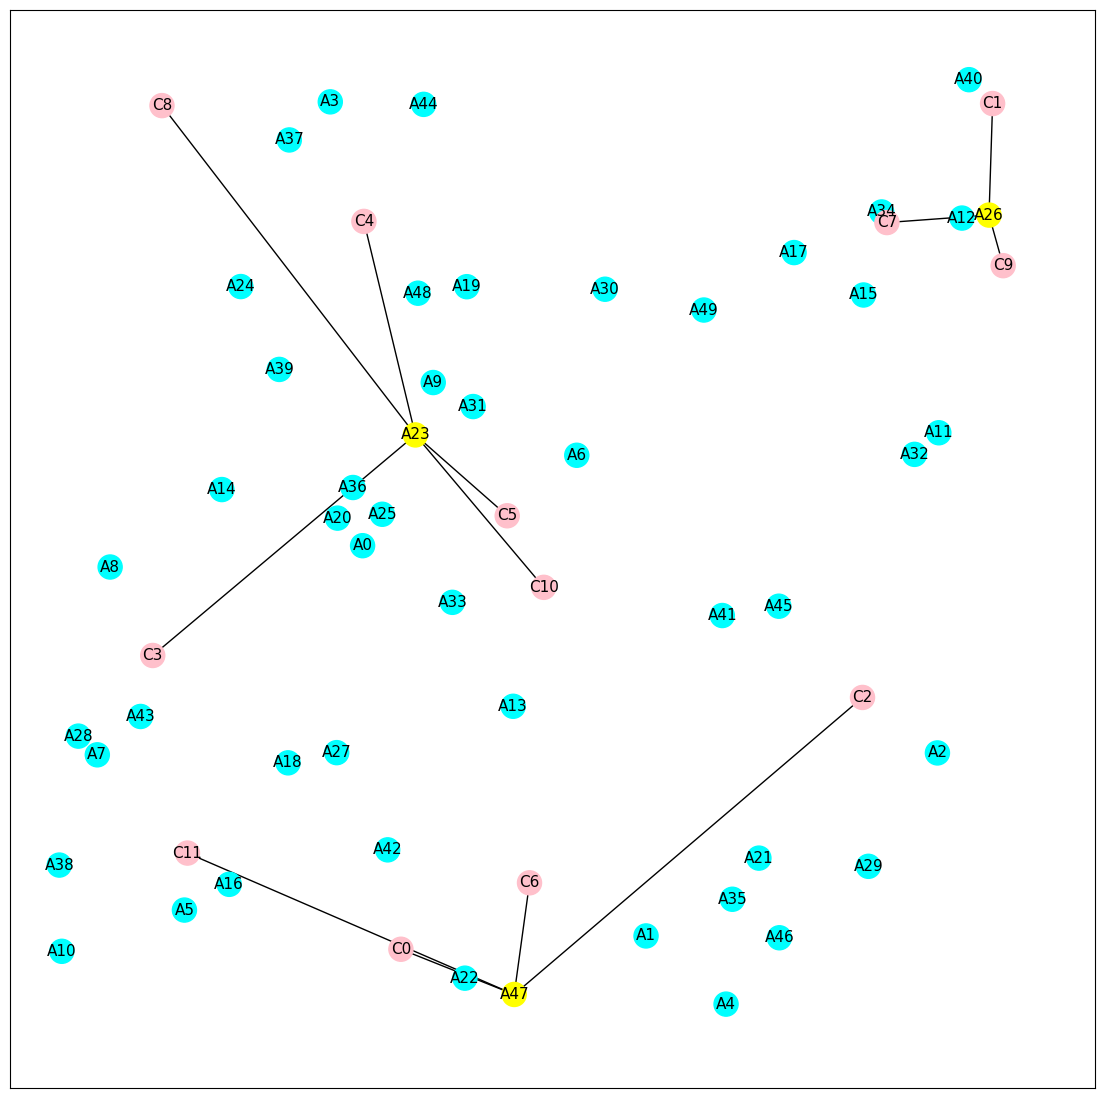

In [11]:
m.optimize()

def print_result(m,x,y):

    import networkx as nx
    import matplotlib.pyplot as plt
    
    print(f"Cost: {m.objective_value:.2f} M euro")

    print("Airports:")
    for j in M:
        if y[j].x > 1e-7:
            print(f"{j:3d} --> {y[j].x:7.3f}; cities: ", end='')
            for i in N:
                if x[i,j].x > 1e-7:
                    print(f"{i} ({x[i,j].x:.2f}); ", end='')
            print('')
    # Visualize solution on graph
    pos_a = {f'A{j}': (a_crd[j][0], a_crd[j][1]) for j in M}
    pos_c = {f'C{i}': (c_crd[i][0], c_crd[i][1]) for i in N}
    
    nodepos = {**pos_a, **pos_c}
    
    g = nx.Graph()
    g.add_nodes_from([f'A{j}' for j in M])
    g.add_nodes_from([f'C{i}' for i in N])
    edges = [(f'A{j}', f'C{i}') for j in M for i in N if x[i,j].x > 0] 
    g.add_edges_from(edges)
    color = ['yellow' if y[j].x > 1e-6 else 'cyan' for j in M] + ['pink']*ncities
    plt.figure(1, figsize=(14,14))
    nx.draw_networkx(g, font_size=11, pos=nodepos, node_color=color)
    plt.show()
    
print_result(m,x,y)

What's going on here? Well, there should be three airports but a lot more are selected. If you wrote the LP relaxation correctly, there are some $y_j$ that are neither 0 nor 1. The number of nonzero $y_j$ is greater than $p$.

Also, airport 36 is built but used by nobody. This is because we request that there be _exactly_ $p$ airports, and the cheapest one is picked to satisfy that constraint.

Given how many $y_j$ are fractional, we can consider this relaxation as weak. To strengthen the formulation, consider the current _logic_ constraint, which means _"For each airport $j$, if more than one $x_{ij}$ is one, then $y_j$ must be one"_:

$$
\sum_{i \in N} x_{ij} \le n y_j \qquad \forall j\in M.
$$

Another way to express it is as follows: _"For each airport $j$ and each city $i$, if $x_{ij}$ is one, then $y_j$ must be one"_. That is, $x_{ij} = 1 \Rightarrow y_j = 1 \, \forall i\in N, j\in M$. This can be written as a linear constraint:

$$
x_{ij} \le y_j \qquad \forall i\in N, j\in M.
$$

There are more such constraints ($nm$) than the original ones, but some of these _tighter_ constraints are violated by the current solution: for instance, $x_{43} = 1$ while $y_3 = 0.167$. We could add $x_{43} \le y_3$ to the problem and resolve, then check the new lower bound.

Cost: 4687.64 M euro
Airports:
 23 -->   1.000; cities: 3 (1.00); 4 (1.00); 5 (1.00); 8 (1.00); 10 (1.00); 
 26 -->   1.000; cities: 1 (1.00); 7 (1.00); 9 (1.00); 
 47 -->   1.000; cities: 0 (1.00); 2 (1.00); 6 (1.00); 11 (1.00); 


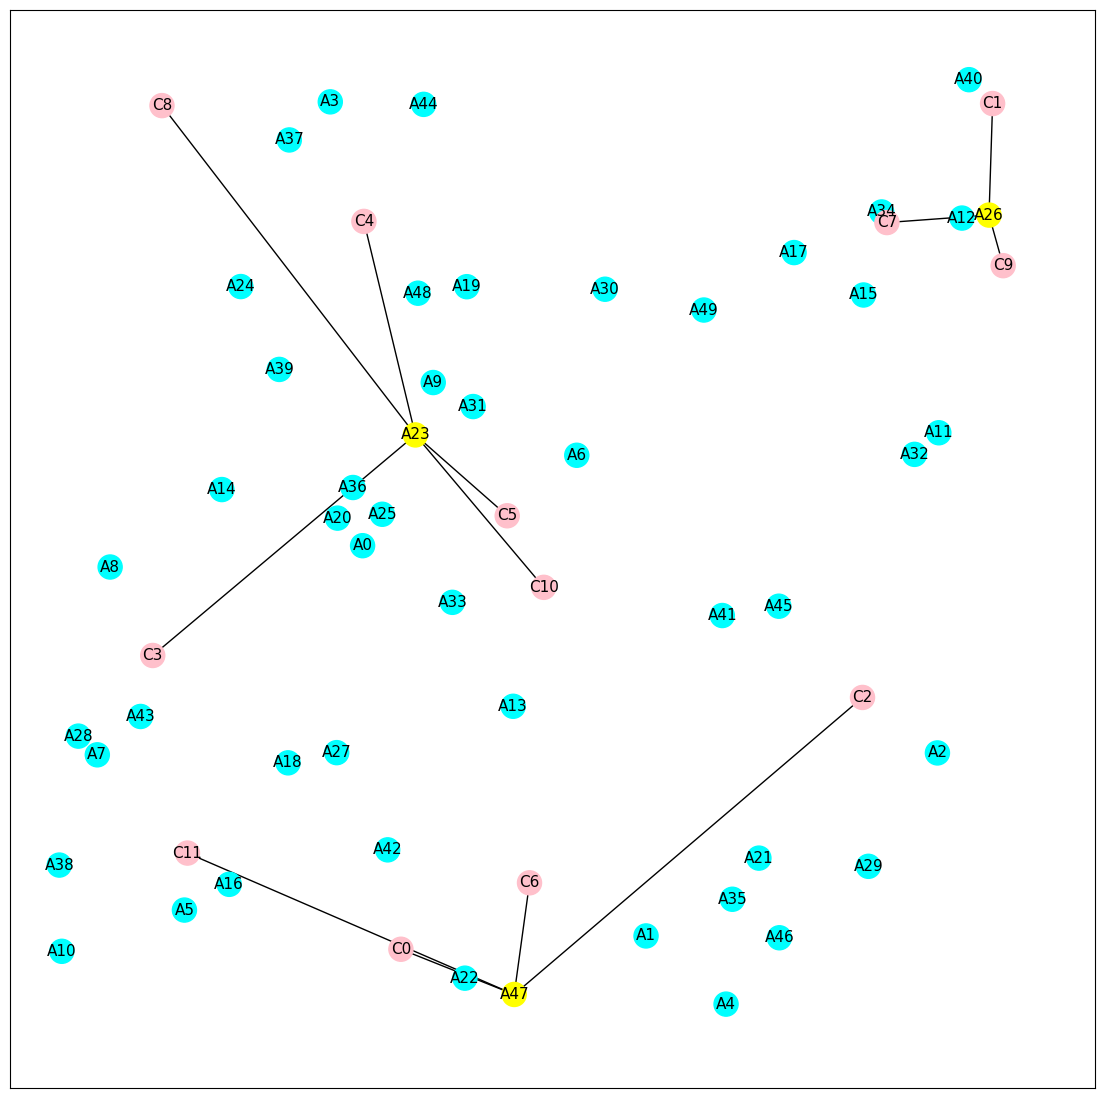

In [13]:
# Add cut x_43 <= y_3 TODO
m.add_constr(x[4,3]<=y[3])
m.optimize()
print_result(m,x,y)

What happened now? A few things:

1. The constraint we just added is obviously satisfied;
2. The lower bound increased by roughly 20;
3. Now one variable $x_{ij}$ is fractional, which didn't happen before.

Let's repeat the previous step with airport 3 and city 8.

Cost: 4687.64 M euro
Airports:
 23 -->   1.000; cities: 3 (1.00); 4 (1.00); 5 (1.00); 8 (1.00); 10 (1.00); 
 26 -->   1.000; cities: 1 (1.00); 7 (1.00); 9 (1.00); 
 47 -->   1.000; cities: 0 (1.00); 2 (1.00); 6 (1.00); 11 (1.00); 


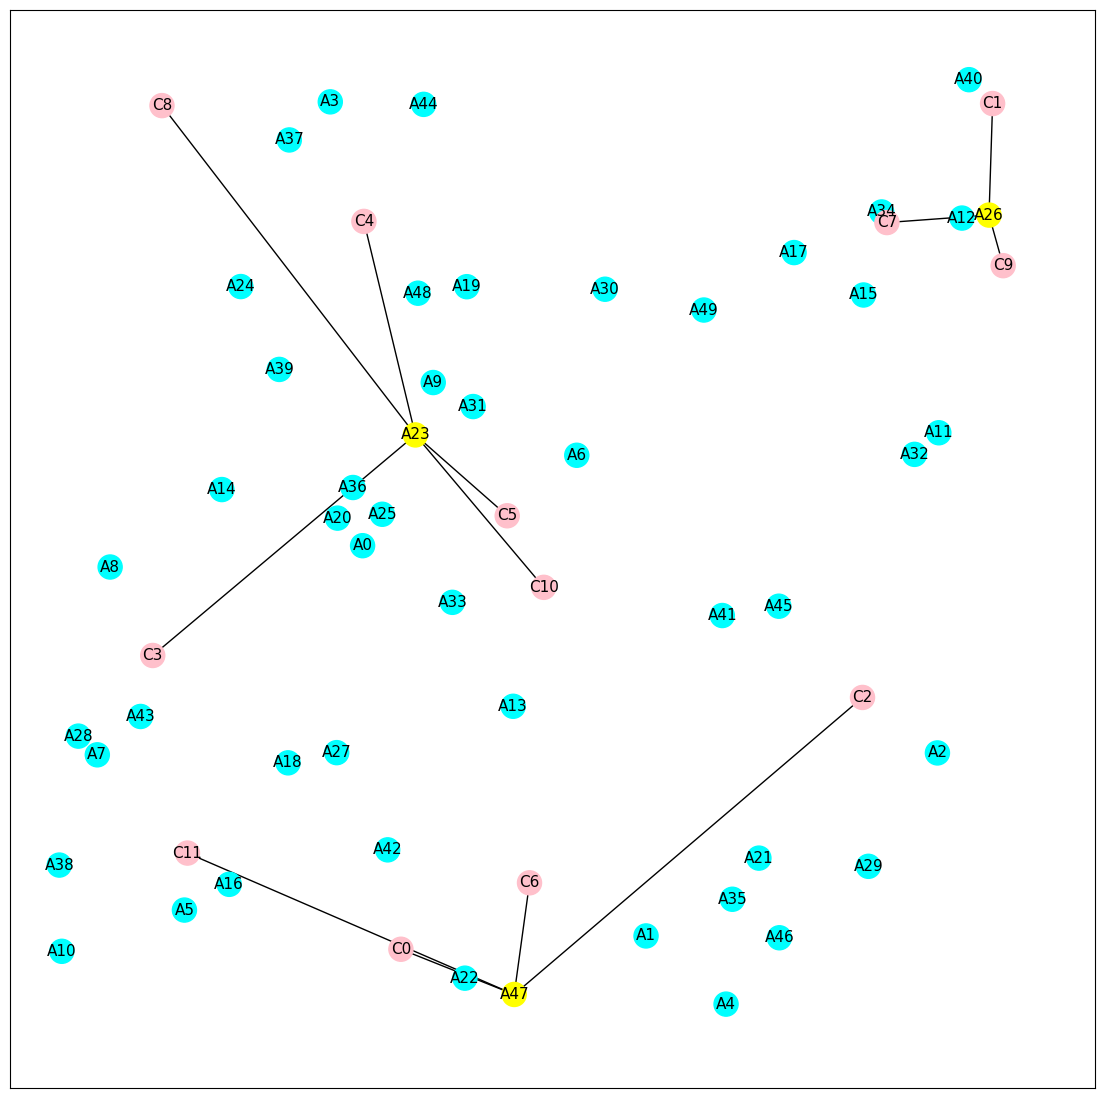

In [14]:
# Add constraint x_83 <= y_3 TODO
# Optimize
# call function for printing and visualizing result
m.add_constr(x[8,3]<=y[3])
m.optimize()
print_result(m,x,y)

Ha! Airport 3 is no longer cost-effective, the new solution excludes it altogether, i.e. $y_3 = 0$. The lower bound increased by quite a bit.

Let's add another inequality for airport 24 and see what happens.

Cost: 4687.64 M euro
Airports:
 23 -->   1.000; cities: 3 (1.00); 4 (1.00); 5 (1.00); 8 (1.00); 10 (1.00); 
 26 -->   1.000; cities: 1 (1.00); 7 (1.00); 9 (1.00); 
 47 -->   1.000; cities: 0 (1.00); 2 (1.00); 6 (1.00); 11 (1.00); 


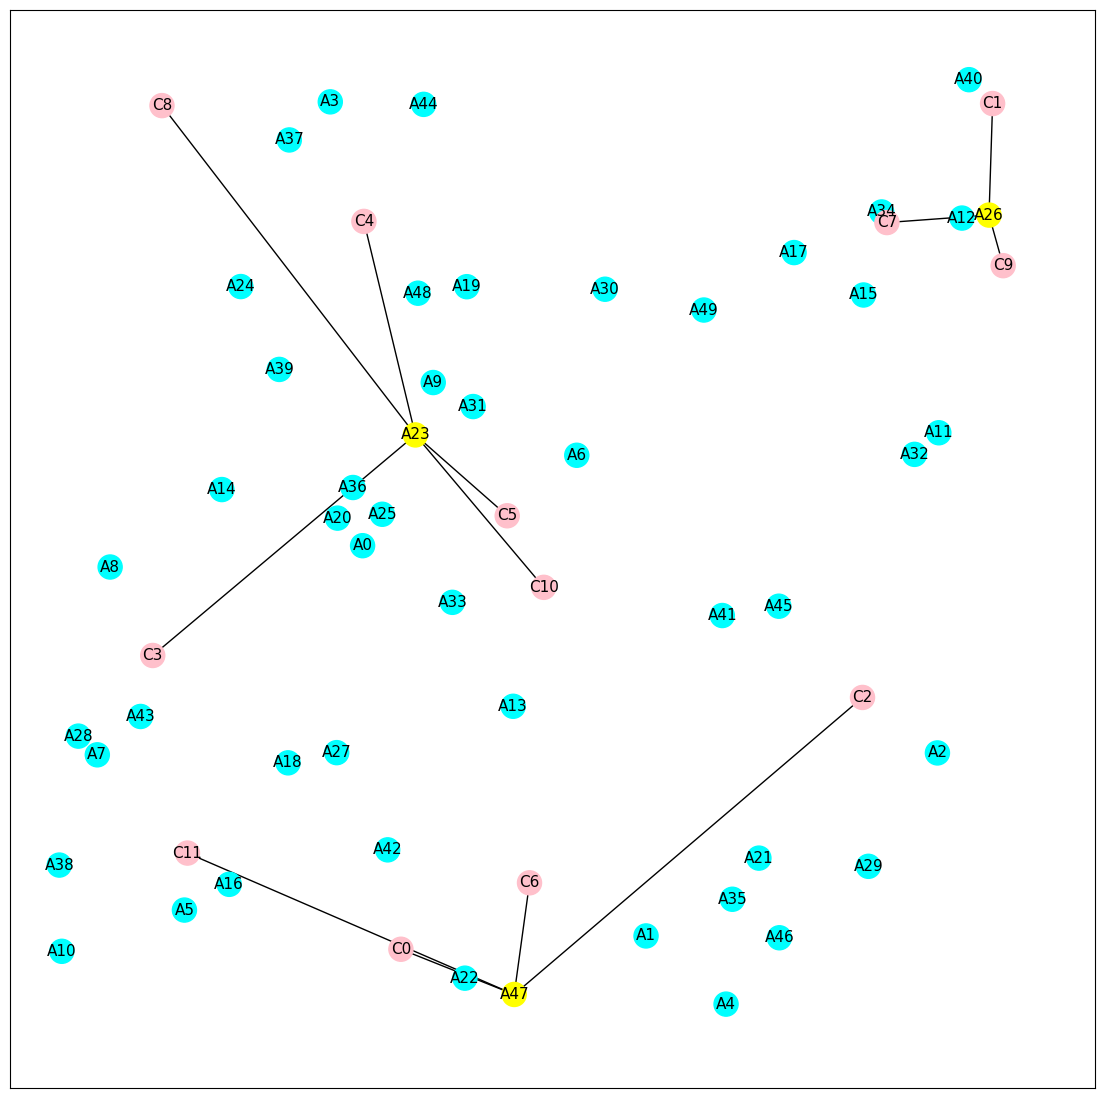

In [15]:
# Add constraint x_83 <= y_3 TODO
# Optimize
# call function for printing and visualizing result
m.add_constr(x[8,3]<=y[3])
m.optimize()
print_result(m,x,y)

As before, airport 24 vanished from the solution. We can envision an algorithm that:
1. solves the problem and retrieves the values of all $x$ and $y$;
2. checks if there is any city/airport pair $(i,j)$ such that the inequality $x_{ij} \le y_j$ is violated;
3. adds the inequality to the problem and repeats from step 1; this is called the _separation_ step, because we separate the current solution from the feasible set.
This is a _cutting plane_ algorithm, because it iteratively adds a linear inequality that cuts off the current solution. The algorithm stops when no such inequality is found.

new objective: 4687.6354274403
Cost: 4687.64 M euro
Airports:
 23 -->   1.000; cities: 3 (1.00); 4 (1.00); 5 (1.00); 8 (1.00); 10 (1.00); 
 26 -->   1.000; cities: 1 (1.00); 7 (1.00); 9 (1.00); 
 47 -->   1.000; cities: 0 (1.00); 2 (1.00); 6 (1.00); 11 (1.00); 


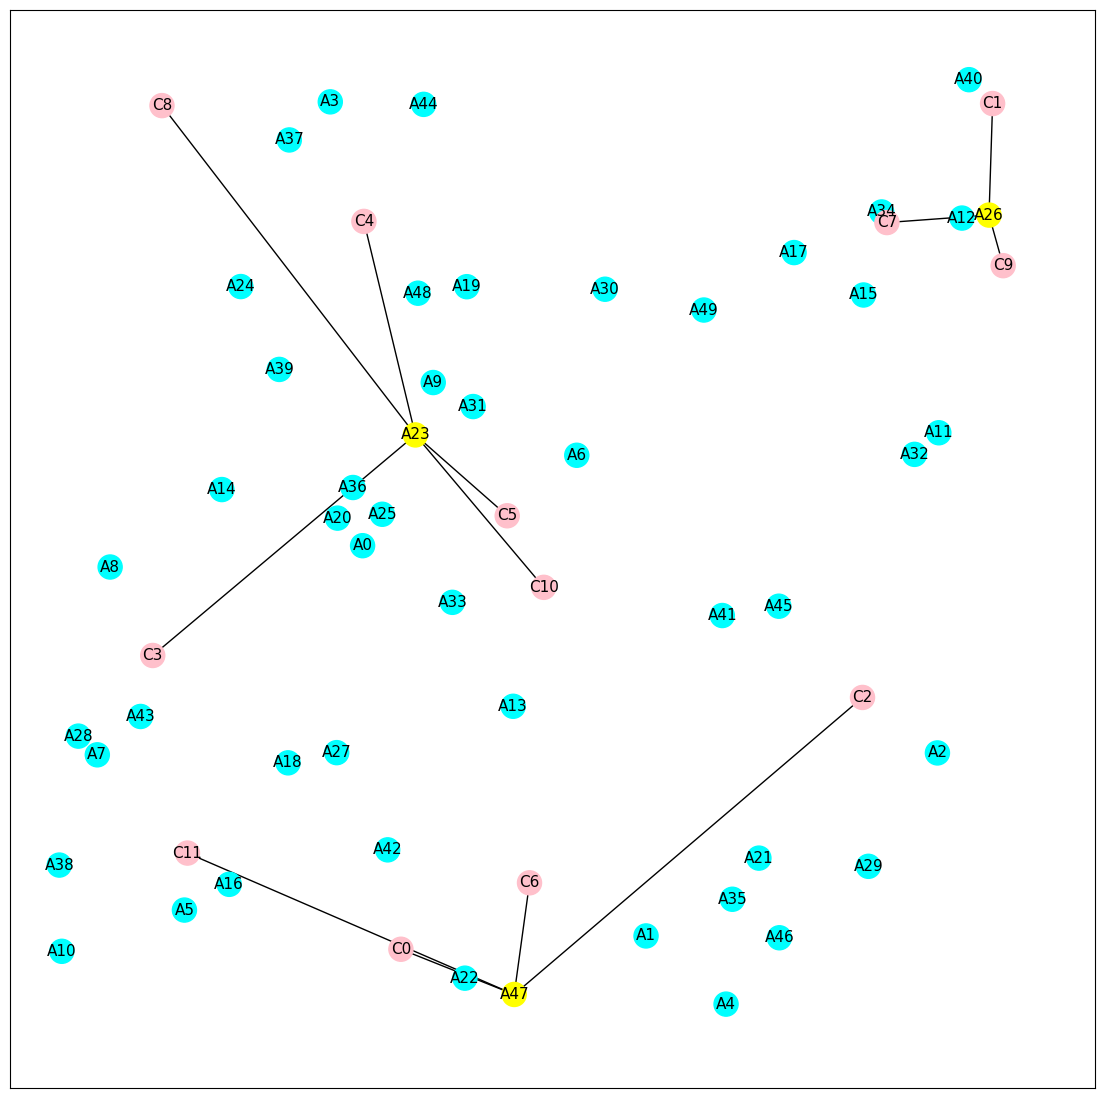

In [16]:
eps = 1e-5

while True:

    m.optimize()
    print(f"new objective: {m.objective_value}")

    pair = None  # Initialize pair to None, leave the loops

    for i in N:
        for j in M:
            # Check if inequality is violated (Add an epsilon to avoid numerical problems) TODO
            if x[i,j].x > y[j].x + eps:
                pair = (i,j)
                break  # Leave the inner loop
        if pair != None:
            break  # Leave the outer loop if an inequality is found

    if pair == None:
        break  # No violated inequality was found, leave the loop

    i,j = pair

    # Add violated constraint TODO
    m.add_var(x[i,j]<=y[j])
    m.optimize()

    print(f"separated x[{i},{j}] <= y[{j}]", end='')
    
print_result(m,x,y)

If all went as planned, we should have an _integer_ solution without even specifying integrality of the variables in the original problem. We solved the ILP problem to optimality without using an ILP solver! All we did was adding some extra constraints and solve an LP problem; the optimal LP solution we found happens to be optimal for the ILP as well because it is integer __and__ because the LP is a relaxation of the ILP problem.

This does __not__ happen all the time, and it may happen that after separating many such inequalities we still have a fractional solution.

Also, note that the lower bound went from ~4106 to ~4687.

## Extra questions

1. What happens if we convert the constraint about the $p$ airport into a $\ge$ or a $\le$ constraint? Will the objective function increase or decrease in either case?
2. What happens to the solution and the objective function value if we drop that constraint altogether?